## Module 2.1: Working with MLPs in Keras (A Review)

This is a quick review of working with MLPs. We want to get everyone on the same level as we proceed. In this module we will pay attention to:
1. Using the Keras functional API for defining models.
2. Implementing different types of regularization.
3. Implementing batch normalization.
4. Working with validation data and early stopping.

Those students who are comfortable with all these matters might consider skipping ahead.

Note that we will not spend time tuning hyper-parameters: The purpose is to show how different techniques can be implemented in Keras, not to solve particular data science problems as optimally as possible. Obviously, most techniques include hyper-parameters that need to be tuned for optimal performance.

In [1]:
# We will always initially perform all required imports
import pandas as pd 

import numpy as np

import matplotlib.pyplot as plt

from keras import Sequential
from keras.layers import Input, Dense, GaussianNoise, Dropout, BatchNormalization, Activation
from keras.utils.vis_utils import model_to_dot
from keras.models import Model
from keras.constraints import UnitNorm
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras.datasets import boston_housing

Using TensorFlow backend.


We will start by loading a simple data set to work with. We will use the Boston housing price regression data that is included in Keras.datasets.

In [2]:
(x_train, y_train), (x_test, y_test) = boston_housing.load_data()

57344/57026 [==============================] - 0s 2us/step


In the next few code boxes we see a basic implementation of an MLP based approach to modeling the above dataset, of the sort that is found in many beginner tutorials. The MLP involved has two hidden layers, with four nodes in each.

We set up the network by adding layers, then compile it and train it using our training data.

In [3]:
def define_model_1 (input_shape):
    model = Sequential()
    model.add(Dense(input_dim=input_shape,units=14,activation="relu", 
                    name = "Hidden1"))
    model.add(Dense(units=6,activation="relu",name = "Hidden2"))
    model.add(Dense(units=1,activation="linear",name="Output"))
    return model

Now we will define and compile the model. We'll use the adam optimizer with (binary) cross-entropy loss and track the accuracy.

In [4]:
model=define_model_1(x_train.shape[1])
model.compile(optimizer ='adam',
              loss='mean_squared_error')

We can easily get a summary of our model.

In [5]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Hidden1 (Dense)              (None, 14)                196       
_________________________________________________________________
Hidden2 (Dense)              (None, 6)                 90        
_________________________________________________________________
Output (Dense)               (None, 1)                 7         
Total params: 293
Trainable params: 293
Non-trainable params: 0
_________________________________________________________________


Now we fit the model to the training dataset.

In [6]:
history=model.fit(x_train,y_train, batch_size=64, epochs=1000) 

00
404/404 [==============================] - 0s 54us/step - loss: 12.8563
Epoch 772/1000
404/404 [==============================] - 0s 47us/step - loss: 12.8539
Epoch 773/1000
404/404 [==============================] - 0s 52us/step - loss: 12.8849
Epoch 774/1000
404/404 [==============================] - 0s 52us/step - loss: 12.9481
Epoch 775/1000
404/404 [==============================] - 0s 52us/step - loss: 12.7702
Epoch 776/1000
404/404 [==============================] - 0s 54us/step - loss: 13.0985
Epoch 777/1000
404/404 [==============================] - 0s 57us/step - loss: 13.0723
Epoch 778/1000
404/404 [==============================] - 0s 47us/step - loss: 12.8297
Epoch 779/1000
404/404 [==============================] - 0s 50us/step - loss: 12.7545
Epoch 780/1000
404/404 [==============================] - 0s 54us/step - loss: 12.8238
Epoch 781/1000
404/404 [==============================] - 0s 50us/step - loss: 12.8285
Epoch 782/1000
404/404 [==============================]

Let's make a function to graph the mean squared error loss during training from the history object returned by model.fit, and then call this function.

In [7]:
def plot_training_history_1(history):
    plt.plot(history.history['loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.gca().set_ylim(0,150)
    plt.gca().set_xlim(0,len(history.history['loss']))
    plt.show()

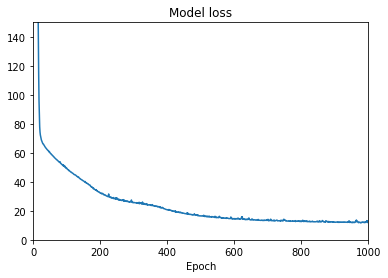

In [8]:
plot_training_history_1(history)

We'll also create a function that examines how well a model does on known data by means of a confusion matrix, and call it with our basic model and test data.

In [9]:
def test_model(model,x,y):
    y_pred = model.predict(x)
    mse=np.mean((y - y_pred)**2)
    print ("Mean Squared Error: {}".format(mse))

In [10]:
test_model(model,x_test,y_test)

Mean Squared Error: 150.88917579522652


## Improving our simple implementation: Step 1

The above code is both basic and **bad**. We will go through looking at how we can change things to both make it reasonable - by using validation data, regularization, batch normalization and early stopping) - as well as introducing more advanced Keras functionality. There are four changes we will make.

Later in this course we are going to end up looking at models that include multiple input and output layers and/or shared layers. To work with these we will want to use keras' functional API and the keras.Model function rather than keras.Sequential.

**So our first change will be to alter our define_model function to use the functional API instead of a Sequential model.**

In [11]:
def define_model_2 (input_shape):
    # We start by defining the input layer using Input. 
    # This returns a tensor
    inputs = Input(shape=(input_shape,),name="Input")
    
    # Now we create the remaining layers. A layer instance is 
    # a function that is callable on a tensor, and returns a tensor.
    hidden1 = Dense(14, activation='relu',name="Hidden1")(inputs)
    hidden2 = Dense(6, activation='relu',name="Hidden2")(hidden1)
    outputs = Dense(1, activation='linear',name="Output")(hidden2)
    
    # Now we use the model function to creates a model that includes 
    # the input layer through to the output layer. Note that each 
    # layer knows its predecessor/input layer, so the model graph 
    # can be traced back from outputs until it reaches inputs.
    model = Model(inputs=inputs, outputs=outputs)
    return model

## Improving our simple implementation: Step 2

We typically need to regularize our neural networks. Regularization provides a means of controlling the complexity of a model without changing its structure (i.e. its basic parametric equation). Common forms of regularization include:
    - L1/L2 regularization, which restricts the ability of model parameters to freely take on large values by means of penalizing large L1 or L2 norms of the weight vector. L2 regularization is also known as weight decay. You can read more about L1 and L2 regularization in Keras [here](https://machinelearningmastery.com/how-to-reduce-generalization-error-in-deep-neural-networks-with-activity-regularization-in-keras/).
    - Weight constraints, which constrains the weights to have a particular norm. You can read more about weight constraints [here](https://machinelearningmastery.com/how-to-reduce-overfitting-in-deep-neural-networks-with-weight-constraints-in-keras/).
    - Dropout, which (under one interpretation) restricts the ability of model parameters to jointly tune. You can read more
about dropout [here](https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/).
    - Noise injection, which restricts the ability of the model parameters to fit themselves to exact values found in the training data. Read more about using noise injection with keras.Sequential models and a case study [here](https://machinelearningmastery.com/how-to-improve-deep-learning-model-robustness-by-adding-noise/).

**For our second improvement, let's change the above code to include L2 regularization.**

Note that you will see dropout, weight constraints and noise injection regularization methods in later modules.

In [12]:
# In this version, when we create the hidden layers, we add l2 
# regularization (also known as weight decay). 
# 
# We have to provide a hyper-parameter to specify the degree of 
# regularization to be imposed. We could have different degrees 
# of regularization for each layer, but we will not. Instead we 
# will allow the user to specify the degree of regularization to
# be used in both layers, and give a default value of .1.
#
# Note that L1 regularization is applied in an analgous way, only 
# using regularizers.l1 instead of regularizers.l2.
def define_model_3 (input_shape,l2_param=.1):
    inputs = Input(shape=(input_shape,),name="Input")
    
    # Now we add regularization to the hidden layers
    hidden1 = Dense(14, activation='relu',name="Hidden1",
                   kernel_regularizer=l2(l2_param))(inputs)
    hidden2 = Dense(6, activation='relu',name="Hidden2",
                   kernel_regularizer=l2(l2_param))(hidden1)

    outputs = Dense(1, activation='linear',name="Output")(hidden2)
    model = Model(inputs=inputs, outputs=outputs)
    return model

## Improving our simple implementation: Step 3

We normally want to speed up the training process as much as possible. Batch normalization is a technique that helps do this by seeking to minimize the changes to distributions that latter layers have to learn during the fitting process. Read more about batch normalization [here](https://towardsdatascience.com/batch-normalization-in-neural-networks-1ac91516821c).

**For our third improvement, let's change the above code to include batch normalization.**

In [13]:
def define_model_4 (input_shape,l2_param=.1):
    inputs = Input(shape=(input_shape,),name="Input")

    # We do not want any activation function defined inside
    # the layer. To do this we just need to not specify any 
    # (by default the activation of a Dense layer is None). 
    # We also do not want a bias node/weight, since the batch 
    # normalization has a parameter that takes care of that.
    # So we set use_bias to False.
    hidden1 = Dense(14,name="Hidden1",use_bias=False, 
                    kernel_regularizer=l2(l2_param))(inputs)
    # By adding the Batch Normalization layer here, we apply a 
    # transformation that maintains the mean close to 0 and the 
    # activation standard deviation close to 1. This is done *prior*
    # to the application of the activation function.
    batch1 = BatchNormalization(name="BatchNorm1")(hidden1)
    # Now we apply the activation function.
    act1 = Activation("relu",name="Activation1")(batch1)

    # We do the same thing with the second hidden layer
    hidden2 = Dense(6,name="Hidden2",use_bias=False, 
                    kernel_regularizer=l2(l2_param))(act1)
    batch2 = BatchNormalization(name="BatchNorm2")(hidden2)
    act2 = Activation("relu",name="Activation2")(batch2)

    # Now we do the output layer and the model
    outputs = Dense(1, activation='linear',name="Output")(act2)
    model = Model(inputs=inputs, outputs=outputs)
    return model

## Improving our simple implementation: Step 4
 
We want to find the parameter (weight) values that minimize the expected error on new data, not the error on training data. So we should be using validation data to evaluate the performance of the model after each epoch, and choose the final weights that correspond to optimal performance on this validation data.

**For our final improvement, when training we will evaluate the performance of our model after each epoch using validation data, and combine this with an early stopping callback that will both stop training once performance on the validation data deteriorates and load the weights associated with best performance on the validation data into our final model.** 

In [14]:
# Let's define our model using our improved code.
model=define_model_4(x_train.shape[1])

# And we will compile it.
model.compile(optimizer ='adam',
              loss='mse')

# Before calling fit, we create the Early Stopping callback. 
# We set it up to stop if improvement in the validation loss 
# does not occur over 15 epochs. When stopping occurs, the 
# weights associated with the best validation loss are restored.
earlyStopping = EarlyStopping(monitor="val_loss", 
                              patience=15,
                              verbose=1,
                              restore_best_weights=True)

# Using validation_split in the model.fit function can be dangerous as 
# it takes last rows prior to shuffling. If data order is not random, this
# can lead to introduction of bias into the data. It is OK here since 
# the data was shuffled during the train/test split above.    
history=model.fit(x_train, 
                  y_train, 
                  epochs=1000, 
                  batch_size=10, 
                  shuffle=True, 
                  validation_split=.2, 
                  callbacks=[earlyStopping])

Train on 323 samples, validate on 81 samples
Epoch 1/1000
323/323 [==============================] - 1s 2ms/step - loss: 579.6905 - val_loss: 646.3293
Epoch 2/1000
323/323 [==============================] - 0s 517us/step - loss: 570.6674 - val_loss: 644.4441
Epoch 3/1000
323/323 [==============================] - 0s 514us/step - loss: 562.3249 - val_loss: 643.6678
Epoch 4/1000
323/323 [==============================] - 0s 477us/step - loss: 553.9753 - val_loss: 637.7086
Epoch 5/1000
323/323 [==============================] - 0s 464us/step - loss: 546.2027 - val_loss: 627.7985
Epoch 6/1000
323/323 [==============================] - 0s 492us/step - loss: 537.3684 - val_loss: 616.6501
Epoch 7/1000
323/323 [==============================] - 0s 452us/step - loss: 529.6736 - val_loss: 603.0001
Epoch 8/1000
323/323 [==============================] - 0s 474us/step - loss: 519.7327 - val_loss: 588.7517
Epoch 9/1000
323/323 [==============================] - 0s 523us/step - loss: 510.5309 - val_

If you want to, run the code below to see the model summary.

In [15]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 13)                0         
_________________________________________________________________
Hidden1 (Dense)              (None, 14)                182       
_________________________________________________________________
BatchNorm1 (BatchNormalizati (None, 14)                56        
_________________________________________________________________
Activation1 (Activation)     (None, 14)                0         
_________________________________________________________________
Hidden2 (Dense)              (None, 6)                 84        
_________________________________________________________________
BatchNorm2 (BatchNormalizati (None, 6)                 24        
_________________________________________________________________
Activation2 (Activation)     (None, 6)                 0   

Let's improve our plot_training_history function so that it also displays both training and validation mean squared error. Then we will call this improved version.

In [16]:
def plot_training_history_2(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Training and Validation Mean Squared Error')
    plt.xlabel('Epoch')    
    plt.gca().set_ylim(0,150)
    plt.gca().set_xlim(0,len(history.history['loss']))
    plt.show()

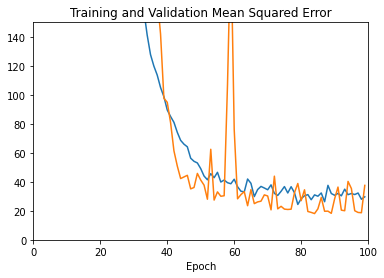

In [17]:
plot_training_history_2(history)

Finally, for fun lets see how our improved model performs on our test data. But remember that we have not spent any time or effort optimizing this model - for a real problem we would determine good values for the l2 regularization, as well as tune the architecture and optimizer.

In [18]:
test_model(model,x_test,y_test)

Mean Squared Error: 143.8043853781698
